# Introduction
This Notebook contains my work for analyzing a 100km transect in the Southern Ocean. The goal is to identify Lee waves from the measurements and then estimate the energy fluxes and transport driven by these lee waves. For some of the more standard plots such as transect contours, I also experiment with my Ocean Toolbox package



In [2]:
# Load Data and relevant modules - this is common to both wayss
%matplotlib inline
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import data_load
import gsw
import oceans as oc
import pandas as pd
import internal_waves_calculations as iwc
import warnings
import cmocean
# Probably Shouldn't do this but they annoy me
warnings.simplefilter("ignore")

pd.options.display.max_rows = 3000

pd.options.display.max_columns = 22


# load data and cut off bottom (its all nans)
ladcp, ctd = data_load.load_data()
strain = np.genfromtxt('strain.csv', delimiter=',')
wl_max = 1000
wl_min = 500
ctd_bin_size = 1024
ladcp_bin_size = 1024
nfft = 2048
U, V, p_ladcp = oc.loadLADCP(ladcp)
S, T, p_ctd, lat, lon = oc.loadCTD(ctd)
rho = gsw.density.rho(S, T, p_ctd)

maxDepth = 4000
idx_ladcp = p_ladcp[:, -1] <= maxDepth
idx_ctd = p_ctd[:, -1] <= maxDepth

strain = strain[idx_ctd, :]

S = S[idx_ctd,:]
T = T[idx_ctd,:]
rho = rho[idx_ctd,:]
p_ctd = p_ctd[idx_ctd, :]
U = U[idx_ladcp, :]
V = V[idx_ladcp, :]
p_ladcp = p_ladcp[idx_ladcp, :]


# Bin CTD data
ctd_bins = oc.binData(S, p_ctd[:, 0], ctd_bin_size)
# Bin Ladcp Data
ladcp_bins = oc.binData(U, p_ladcp[:, 0], ladcp_bin_size)

# Depth and lat/long grids (For plots)
depths = np.vstack([np.nanmean(p_ctd[binIn]) for binIn in ctd_bins])
dist = gsw.distance(lon, lat)
dist = np.cumsum(dist)/1000
dist = np.append(0,dist)

# Extracting Wave Components
This section uses spectral analysis to estimate kinetic and potential energies lee waves. Using a minimum and maximum vertical wavelength as integration limits, I estimate the energetics of target wavelengths. These limits were determined qualitatively by estimative vertical size of features in profiles (how big are the wiggles). 

## Internal Energy
The wave components are estimated through calcuation of the internal wave energy components (Kinetic and Potential). To do this, each profile is seperated into mean and wave-induced perturbations $(X = X + X')$. In order to do this a sliding vertical polynomial is fit to each profile and the resultant profile is subtracted out, leaving the perturbation profile.

### Kinetic Energy
The resultant velocity perturbation profiles (u and v) are binned into 1024 meter, half overlapping bins. The Power Spectral Density is calculated along each being and integrated between a target wavelength band. This band is chosen by examining the perturbation profiles and identifying coherent wave features. The final values are input into the kinetic energy equation. $\langle \rangle$ denotes integrated power spectral density. 

$$ KE = \frac{1}{2}\big[ \langle u'^{2} \rangle + \langle v'^{2} \rangle \big] $$

### Potential Energy 
A similar process is followed for estimating potential energy. However, 2 methods were implemented here, with varying results. The first was to estimate the isopycnal displacement $\eta$ from density perturbations as follows: 

$$\eta = \frac{\rho - \rho_{ref}}{\frac{\Delta \rho_{ref}}{\Delta z}}$$
            
$\rho_{ref}$ is estimated as a transect mean density profile. See **Potential Energy Notebook for this clalculation worked out**
Once $\eta$ is obtained, the same processes for calculating Power Spectral Density used in kinetic energy calculations are used here with the potential energy equation:

$$ PE = \frac{1}{2}N^2\langle \eta'^{2} \rangle $$

The energy components are combined for the total internal energy $(\frac{J}{m^s})$:

$$ E = \rho_{0}(KE + PE) $$

### Frequency and Horizontal Wavenumber
Using the two energy components, the internal wave frequencies are estimated by:

$$ \omega_{0} = f\sqrt{\frac{KE + PE}{KE - PE}}$$

Several other derivations are used and compared with similar results. An issue with this method is that when kinetic and potential energies are similar, error in energy density calculations may cause kinetic energy to be slightly less than potential, resulting in a null value from the square root operation. 
We now have the intrinsic frequency as well as the vertical waveumnber $m$ which is estimated as the mean of integration limits. From here, $k_{h}$, the horizontal wave number is calculated from:

$$  k_{h} = m\sqrt{\frac{f^2 - \omega^2}{\omega^2 - N^2}}$$



In [13]:
# Calculate KE spectrums (m2/s2)
z_ladcp = -1*gsw.z_from_p(p_ladcp, lat)
KE, KE_grid, KE_psd, Uprime, Vprime, ke_peaks = iwc.KE_UV(U, V, z_ladcp, ladcp_bins,
                                                    wl_min, wl_max, lc=wl_min-50,
                                                    nfft=1024, detrend='constant')
# Adiabatic Leveling to get reference densities.

# Order = order of polynomial fit to use
order = 1

# Pressure window - See Bray and Fofonoff 1981 for details
pressure_range = 400 

# axis = the depth increases on
axis = 0

# Use Adiabtic Leveling from Oceans Library
N2_ref, N2, strain, p_mid, rho_bar = oc.adiabatic_level(S, T, p_ctd, lat, pressure_range=pressure_range,
                                                        order=order, axis=axis)

# Stick a nan to the top to make it the same size as the rho array
rho_ref = np.nanmean(rho_bar, axis=1)                                                       
rho_ref = np.hstack((0, rho_ref))

# Eta calculation from oceans library (isopyncal vertical displacement from reference density field)
eta = oc.isopycnal_displacements(rho, rho_ref, p_ctd, lat)


# Calculate PE spectrum using eta from above (m2/s2)
z_ctd = -1*gsw.z_from_p(p_ctd, lat)
PE, PE_grid, eta_psd, N2mean, pe_peaks = iwc.PE(N2, z_ctd, eta,
                                                wl_min, wl_max,
                                                ctd_bins, nfft=1024,
                                                detrend=False)

## Energy Spectrum Plots

Text(0.5,0,'Vertical Wavenumber')

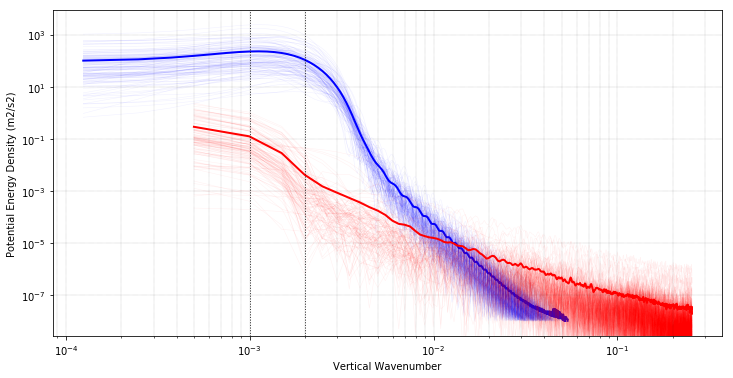

In [15]:
m_plot = np.array([(1)/wl_max,
                       (1)/wl_max, (1)/wl_min,
                       (1)/wl_min])
plt.figure(figsize=[12,6])

plt.loglog(KE_grid, KE_psd.T, linewidth=.6, c='b', alpha=.05)
plt.loglog(KE_grid, np.nanmean(KE_psd, axis=0).T, lw=2, c='b')
ylims = plt.gca().get_ylim()
ylim1 = np.array([ylims[0], ylims[1]])
plt.plot(m_plot[2:], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.plot(m_plot[:2], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.ylim(ylims)
plt.ylabel('Kinetic Energy Density')
plt.xlabel('Vertical Wavenumber')
plt.gca().grid(True, which="both", color='k', linestyle='dotted', linewidth=.2)

plt.loglog(PE_grid, .5*np.nanmean(N2)*eta_psd.T,
           lw=.6, c='r', alpha=.05)
plt.loglog(PE_grid, .5*np.nanmean(N2)*np.nanmean(eta_psd, axis=0).T,
           lw=2, c='r')
plt.plot(m_plot[2:], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.plot(m_plot[:2], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.ylim(ylims)
# plt.gca().grid(True, which="both", color='k', linestyle='dotted', linewidth=.2)
plt.ylabel('Potential Energy Density (m2/s2)')
plt.xlabel('Vertical Wavenumber')
plt.title('Kinetic And Potential Energy Spectrum')
# plt.xlim(.0005, .01)

## Decompose Horizontal Wave Vector
In order to properly run a ray tracing model, the horizontal wavenumber $k_h$ must be decomposed into its two components, $k$ and $l$. The horizontal azimuth, $\theta$, is the angle between the $k_h$ vector and the x-axis. using the relationships:
$$ tan(2\theta) = 2\mathbb{R} \bigg [\frac{u'^{*}v'}{u'u^{*} - v'v^{*}} \bigg ]$$

$$ k = (kh)cos(\theta) $$
$$ l = (kh)sin(\theta) $$

where $*$ represents the complex conjugate and $u'$ and $v'$ represent the Fourier transform of velocity anomalies. 
Fourier transforms are done along the same bins used in the energy calculations. **NOT SO SURE ABOUT HOW RIGHT THIS IS **



In [5]:
# Horizontal wave vector decomposition
k = []
l = []

theta = []
dz = 8

for i in ladcp_bins:
    theta.append(iwc.horizontal_azimuth(Uprime[i,:], Vprime[i,:], dz,\
                                        wl_min=wl_min,
                                        wl_max=wl_max,
                                        nfft=1024))
theta = np.vstack(theta)

k = kh*np.cos(theta)
l = kh*np.sin(theta)

** Note: For ray tracing experiments see lee_waves_v2 notebook, the follow work deals with dissipation rate calculations
**

## Dissipation rate calculation - Thorpe Scales
Thorpe scales are used to estimate the local dissipation rate, which will be compared to the estimated dissipation rate of the obeserved internal waves. For each bin, the density profile is resorted into monotonic order and the root mean square of the vertical displacements is calculated as the Thorpe Scale. This length scale is related empirically to the dissipation rate following the work of [@Meter et al. 2015]. 



In [9]:
import importlib
importlib.reload(oc)

<module 'oceans' from '/Users/mdevana/Documents/Lee_waves_dissertation/oceans.py'>